In [1]:
#importing libraries

import pandas as pd
import math
import numpy as np
from datetime import datetime,date
import pytz
import sklearn as skl
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler  
from IPython.core.ultratb import VerboseTB
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
VerboseTB._tb_highlight = "bg:#039dfc"
import scipy.optimize as spo
import time

In [2]:
# class for technical indicators. I receives a dataframe and returns, for each method, 
# a new column with the values calculated based on an input column.

class TechnicalIndicators():
    def __init__(self, data_frame):
        self.df = data_frame.copy()

    # calculation of the return of column after an interval of n days
    def momentum(self, column, n, offset=0):
        if f'{column}_momentum_{n}*' not in self.df.columns:
            close_prices = self.df.loc[offset:,column]
            momentum = close_prices / close_prices.shift(n) - 1
            momentum[0:n]=1
            self.df[f'{column}_momentum_{n}'] = momentum
            
        return self.df[f'{column}_momentum_{n}']
    
    # moving average of column i of returns through n days
    def simple_movement_average(self, column, n, offset=0):
        if f'{column}_sma_{n}*' not in self.df.columns:
            window_mean = self.df.loc[offset:,column].rolling(n).mean()
            window_mean[0:n]=  window_mean[n]
            self.df[f'{column}_sma_{n}'] = self.df[column] / window_mean - 1
        return self.df[f'{column}_sma_{n}']
    
    # calculate upper and lower 2*std_deviation lines
    def _get_bollinger_bands(self, rm, rstd):
        upper_band = rm + rstd * 2
        lower_band = rm - rstd * 2
        return upper_band, lower_band
    
    # moving average and +/- 2*std_deviation lines
    def bollinger_bands(self, column, window_size=20, offset=0):
        if f'{column}_upper_band*' not in self.df.columns:
            self.df[f'{column}_mm20'] = self.df.loc[offset:,column].rolling(window_size).mean()
            self.df.loc[0:window_size,f'{column}_mm20'] =  self.df.loc[window_size,f'{column}_mm20']
            rstd = self.df.loc[offset:,column].rolling(window_size).std()
            rstd.iloc[0:window_size] = rstd.iloc[window_size]
            self.df[f'{column}_upper_band'], self.df[f'{column}_lower_band'] = self._get_bollinger_bands(self.df[f'{column}_mm20'], rstd)
        return self.df[[column, f'{column}_mm20', f'{column}_upper_band', f'{column}_lower_band']]
    
    # daily and cumulative returns of column
    def add_daily_return(self,column):
        self.df[f'{column}_daily_return'] = (self.df[column] / self.df[column].shift(1)) - 1
        self.df.loc[0,f'{column}_daily_return'] = 0
        self.df[f'{column}_cumulative_return'] = (self.df[column] / self.df[column].values[0]) - 1
        self.df.loc[0,f'{column}_cumulative_return'] = 0
        
    # log return after n days of column
    def log_returns(self,column,n):
        self.df[f'{column}_log_return_{n}'] = np.log((self.df[column] / self.df[column].shift(n)))
        self.df.loc[0:n,f'{column}_log_return_{n}'] = self.df.loc[n,f'{column}_log_return_{n}']
        return self.df[f'{column}_log_return_{n}']
    
    

In [3]:
# get stock (ticker) data from yahoo finance from start to end dates
class stock_dataframe():
    def __init__(self,ticker,start,end):
        self.ticker = ticker
        self.start = start 
        self.end = end
        
    def get_stock_data(self):
        start_date = date.fromisoformat(self.start)
        end_date = date.fromisoformat(self.end)
        start_stamp = int(datetime(start_date.year, start_date.month, start_date.day, tzinfo=pytz.UTC).timestamp())
        end_stamp = int(datetime(end_date.year, end_date.month, end_date.day, tzinfo=pytz.UTC).timestamp())
        print(start_date, end_date)
        #self.start_stamp = datetime.timestamp(self.start_date)
        #self.end_stamp = datetime.timestamp(self.end_date)
        print(start_stamp,end_stamp)
        url = "https://query1.finance.yahoo.com/v7/finance/download/%s?period1=%i&period2=%i&interval=1d&events=history&includeAdjustedClose=true" % (self.ticker,start_stamp,end_stamp)
        print(url)
        self.stock = pd.read_csv(url)
        print(self.stock)
        self.stock.rename(columns={"Adj Close":"AC"}, inplace=True)
        self.stock["Relative_High"] = self.stock["High"]/self.stock["AC"]
        self.stock["Relative_Low"] = self.stock["Low"]/self.stock["AC"]
        self.stock["Relative_Open"] = self.stock["Open"]/self.stock["AC"]
        return self.stock
    
    # Convert Date to Day, Month and Year columns.
    def Date_Convert(self):
        self.stock['Date'] = pd.to_datetime(self.stock['Date'])
        self.stock['Year'] = self.stock['Date'].dt.year
        self.stock['Month'] = self.stock['Date'].dt.month
        self.stock['Day'] = self.stock['Date'].dt.day
        
    # define Scaler
    def Standard_Scaler(self):
        self.scaler = StandardScaler()
    
    def Min_Max_Scaler(self):
        self.scaler = MinMaxScaler()
        
    # Calculate technical indicators    
    def Get_Technical_Indicators(self,price):
        TI = TechnicalIndicators(self.stock)
        TI.momentum(price,15)
        TI.simple_movement_average(price,15)
        TI.bollinger_bands(price,15)
        TI.add_daily_return(price)
        TI.log_returns(price,1)
        self.stock = TI.df
        return self.stock
        
    # Perform Chosen normalization    
    def Normalize(self):
        # Define the column to leave unchanged
        unchanged_column = 'Date'

        # Create a subset of columns excluding the unchanged column
        columns_to_scale = [col for col in self.stock.columns if col != unchanged_column]

        # Copy the DataFrame
        stock_normalized = self.stock.copy()

        # Apply StandardScaler to the subset of columns
        stock_normalized[columns_to_scale] = self.scaler.fit_transform(self.stock[columns_to_scale])

        print(stock_normalized)

        # Concatenate the normalized subset with the unchanged column
        stock_normalized = pd.concat([stock_normalized[unchanged_column], stock_normalized[columns_to_scale]], axis=1)

        # rename adjusted close to avoid spaces 

        return stock_normalized



In [4]:
# Merge stock dataframes for all options in a single dataframe 
def merge_stocks(options):
    df = pd.DataFrame()
    for stock in options:
        print("stock =",stock)
        # define stock data class
        stock_data = stock_dataframe(stock,"2010-01-01","2021-12-31")
        
        # read data
        stock_data.get_stock_data()
        
        # convert Date to Day, Month and Year columns
        stock_data.Date_Convert()
        
        # Calculate additional variables
        stock_data.Get_Technical_Indicators("AC")
        
        # Define scaler 
        stock_data.Standard_Scaler()
        
        print("stock_data.stock = ",stock_data.stock)
        # Apply normalization
        df_stock = stock_data.Normalize()
        
        date_columns = ["Date","Year","Month","Day"]
        # Identify columns with identical values across all DataFrames
        identical_columns = []
        distinct_columns = []

        # merge with other options 
        for col in df_stock.columns:
            if (col in df and col in df_stock):
                if df[col].equals(df_stock[col]): identical_columns.append(col)
            else: 
                if col not in date_columns: df_stock.rename(columns={col: stock + '_' + col}, inplace=True)
        # Identify columns with distinct values across the DataFrames
        distinct_columns = [col for col in df_stock.columns if col not in identical_columns]

        df = pd.concat([df,df_stock[distinct_columns]],axis=1)
    print(df)
    return df

In [5]:
# Class for calculating option weights for an optimal portfolio for each day 
class PortfolioOptimization:
    def __init__(self, data_frame, options):
        self.df = data_frame.copy()
        self.options = options.copy()
        self.init_weights()

     # initialize weights        
    def init_weights(self):
        for stock in self.options:
            if f'{stock}_weight' not in self.df.columns:
                self.df[f"{stock}_weight"] = 1 / len(self.options)

    # constraints for optimization. Might not be needed in case W_i/sum(W_i) is used             
    def _constraints(self, weights):
        return np.sum(weights) - 1
    
    # Sharpe ration calculation of the full portfolio. Currently using constant as risk free return
    def sharpe_ratio(self, weights, returns, std, rfree):
        norm_weights = weights / np.sum(weights)
        total_return = np.sum(norm_weights * returns)
        portfolio_stddev = np.sum(norm_weights*norm_weights*std*std)
        return (total_return - rfree) / portfolio_stddev
    
    # Minimize target funcion, maximizing the Sharpe ratio
    def target_function(self, weights, returns, stddev, rfree):
        return -self.sharpe_ratio(weights, returns, stddev, rfree)

    # weight optimization using scikit.optmize.minimize. Might not be the best choice, still can test alternatives. Need to check optimized values 
    def optimize_weights(self, weights, returns, stddev, rfree):
        constraints = {'type': 'eq', 'fun': self._constraints}
        bounds = [(0, 1) for _ in range(len(weights))]

        result = spo.minimize(
            self.target_function,
            weights,
            args=(returns, stddev, rfree),
            constraints=constraints,
            bounds=bounds,
            method='SLSQP'  # Sequential Least Squares Programming optimizer
        )

        if not result.success:
            raise ValueError(f"Optimization failed: {result.message}")

        return result.x
    
    # Apply optimization for each row. 
    def get_optimal_weights(self, rfree):
        weight_columns = [col for col in self.df.columns if col.endswith('_weight')]
        return_columns = [col.replace('_weight', '_AC_log_return_1') for col in weight_columns]
        stddev_columns = [self.df[col].std() for col in return_columns]

        def apply_optimization(row):
            weights = row[weight_columns].values
            returns = row[return_columns].values
            optimal_weights = self.optimize_weights(weights, returns, stddev_columns, rfree)
            return pd.Series(optimal_weights, index=weight_columns)

        # df.apply was tricky to use with a function with many parameters, to be applied in many columns. This was the workaround which worked  
        self.df[weight_columns] = self.df.apply(apply_optimization, axis=1)
        return self.df[weight_columns]

In [6]:
# class for calculating evaluation metrics of the model
class Metrics():
    def __init__(self, in_df, pred_df, targets):
        common_indices = in_df.index.intersection(pred_df.index)
        common_indices = common_indices[:-1]
        self.in_df = in_df.loc[common_indices].copy()
        self.pred_df = pred_df.loc[common_indices].copy()
        self.targets = targets.copy()
        self.out = pd.DataFrame()
        self.mse = {}

    # pull = (predicted - data)/std_dev    
    def pull(self):
        for column in self.targets:
            # Ensure both return Series
            in_series = self.in_df[column].squeeze()
            pred_series = self.pred_df[column].squeeze()
            diff = pred_series - in_series
            in_std = self.in_df[column].std()
            pred_std = self.in_df[column].std()
            pull = diff/math.sqrt(pow(in_std,2) + pow(pred_std,2))
            self.out[f'{column}_Pull'] = pull
        return self.out.filter(like='Pull')

    # chisq = (predicted - data)**2/std_dec**2
    def chisq(self):
        for column in self.targets:
            in_series = self.in_df[column].squeeze()
            pred_series = self.pred_df[column].squeeze()
            diff = pred_series - in_series
            in_std = self.in_df[column].std()
            pred_std = self.in_df[column].std()
            chisq = diff*diff/(pow(in_std,2) + pow(pred_std,2))
            self.out[f'{column}_ChiSq'] = chisq
        return self.out.filter(like='ChiSq')
    
    # mse = sum(chisq)/n_rows for every row
    def get_mse(self):
        for column in self.targets:
            if f'{column}_ChiSq' not in self.out.columns:
                self.chisq()
            self.mse[column] = self.out[f'{column}_ChiSq'].sum()/len(self.out[f'{column}_ChiSq'])
        return self.mse

In [7]:
# MLP regressor model
class model():
    def __init__(self, 
             df, 
             features, 
             targets, 
             train_fraction=0.5, 
             validation_fraction=0.25, 
             rwin=90, 
             offset=1, 
             hidden_layers=[20,20,20], 
             learning_rate=0.0001, 
             tolerance = 0.0001):
        self.df = df.copy()
        self.features = features.copy()
        self.targets = targets.copy()
        self.train_fraction = train_fraction
        self.validation_fraction = validation_fraction
        self.rwin = rwin
        self.offset = offset
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.tolerance = tolerance
    
    # copy all parameters, used to update model during validation
    def set_pars(self,rwin,learning_rate,tolerance,hidden_layers):
        self.rwin = rwin
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.tolerance = tolerance

    # split data in training, validation and test sets
    def split_data(self):
        Train_End = round(self.train_fraction*len(self.df))
        Validation_End = round(self.train_fraction*len(self.df)) + round(self.validation_fraction*len(self.df))
        self.Train_Data = self.df[:Train_End]
        self.Validation_Data = self.df[Train_End:Validation_End]
        self.Test_Data = self.df[Validation_End:]
        return self.Train_Data, self.Test_Data

    # initialize and fill arrays for samples and results                                                                     
    def create_samples(self): 
        self.Train_Sample_Array = []
        self.Train_Result_Array = []
        self.Validation_Sample_Array = []
        self.Validation_Result_Array = []
        self.Test_Sample_Array = []
        self.Test_Result_Array = []

        for i in range(0,len(self.Train_Data)-self.rwin - self.offset):
            #print("i = ", i, "self.rwin =", self.rwin )
            self.Train_Sample = self.Train_Data[self.features].iloc[i:i+self.rwin]
            self.Train_Sample_row = self.Train_Sample.values.ravel()
            self.Train_Sample_Array.append(self.Train_Sample_row)
            self.Train_Result = self.Train_Data[self.targets].iloc[i+self.rwin + self.offset]
            self.Train_Result_Array.append(self.Train_Result.values.ravel())
            #print("Train sample index = ", range(i,i+self.rwin))
            #print("Train_Result index = ", i+self.rwin + self.offset)

        for i in range(0,len(self.Validation_Data)-self.rwin - self.offset):
            self.Validation_Sample = self.Validation_Data[self.features].iloc[i:i+self.rwin]
            self.Validation_Sample_row = self.Validation_Sample.values.ravel()
            self.Validation_Sample_Array.append(self.Validation_Sample_row)
            self.Validation_Result = self.Validation_Data[self.targets].iloc[i+self.rwin + self.offset]
            self.Validation_Result_Array.append(self.Validation_Result.values.ravel())
            #print("Validation sample index = ", range(i,i+self.rwin))
            #print("Validation_Result index = ", i+self.rwin + self.offset)
                                                                         
        for i in range(0,len(self.Test_Data)-self.rwin - self.offset):
            self.Test_Sample = self.Test_Data[self.features].iloc[i:i+self.rwin]
            self.Test_Sample_row = self.Test_Sample.values.ravel()
            self.Test_Sample_Array.append(self.Test_Sample_row)
            self.Test_Result = self.Test_Data[targets].iloc[i+self.rwin + self.offset]
            self.Test_Result_Array.append(self.Test_Result.values.ravel())
            #print("Test sample index = ", range(i,i+self.rwin))
            #print("Test_Result index = ", i+self.rwin + self.offset)

        #print("Train_Sample_Array:",self.Train_Sample_Array)
        #print("Test_Sample_Array:",self.Test_Sample_Array)

        return self.Train_Sample_Array, self.Test_Sample_Array, self.Train_Result_Array, self.Test_Result_Array

    # make prediction for sample from index_start to index_end                                                                     
    def predict(self, sample, index_start, index_end):    
        Result = pd.DataFrame(self.regr_fit.predict(sample),columns=[self.targets])
        New_index_values = range(index_start,index_end)
        Result.index = New_index_values
        return Result
                                                                         
    # train model and make prediction
    def train_model(self):
        train_time = time.time()
        print("rwin = ", self.rwin, "hidden_layers = ", self.hidden_layers, "learning_rate = ", self.learning_rate, "tolerance = ", self.tolerance)
        self.regr = MLPRegressor(random_state=1, 
                                 max_iter=10000, 
                                 hidden_layer_sizes=tuple(self.hidden_layers),
                                 learning_rate_init = self.learning_rate, 
                                 tol = self.tolerance,
                                 alpha = 1.0,
                                activation='tanh')
        self.regr_fit = self.regr.fit(self.Train_Sample_Array, 
                                 self.Train_Result_Array)
        print("training time =", time.time() - train_time)
        Train_start = self.rwin + self.offset
        Train_end = len(self.Train_Data)
        Validation_start = len(self.Train_Data) + self.rwin + self.offset
        Validation_end = len(self.Train_Data) + len(self.Validation_Data)
        Test_start = len(self.Train_Data) + len(self.Validation_Data) + self.rwin + self.offset
        Test_end = len(self.Train_Data) + len(self.Validation_Data) + len(self.Test_Data)
        
        self.Train_Pred = self.predict(self.Train_Sample_Array, 
                                       Train_start,  
                                       Train_end)
        
        self.Validation_Pred = self.predict(self.Validation_Sample_Array, 
                                            Validation_start,  
                                            Validation_end)
        
        self.Test_Pred = self.predict(self.Test_Sample_Array, 
                                      Test_start, 
                                      Test_end)
        return self.regr_fit

    # plot data and prediction for all sets                                                                     
    def plot(self):
        for target in self.targets:
            fig, ax = plt.subplots(figsize=(12, 6))
            self.Train_Data[target].plot(ax=ax, label='Data_'       + target)
            self.Validation_Data[target].plot(ax=ax, label='Data_'       + target)
            self.Test_Data[target].plot(ax=ax, label='Data_'       + target)
            self.Train_Pred[target].plot(ax=ax, label='P'           + target)
            self.Validation_Pred[target].plot(ax=ax, label='P'           + target)
            self.Test_Pred[target].plot(ax=ax, label='P'           + target)
            ax.legend(loc='center left', bbox_to_anchor=(1, 1),fontsize='small')
            #ax.get_legend().get_frame().set_boxstyle("Round,pad=0.5")
            ax.get_legend().get_frame().set_width(5)
            

    # calculate model metrics                                                                    
    def calculate_metrics(self):
        M_Train = Metrics(self.Train_Data[self.targets],self.Train_Pred[self.targets],self.targets)
        self.train_pull  = M_Train.pull()
        self.train_chisq = M_Train.chisq()
        self.train_mse   = M_Train.get_mse()

        M_Validation = Metrics(self.Validation_Data[self.targets],self.Validation_Pred[self.targets],self.targets)
        self.validation_pull  = M_Validation.pull()
        self.validation_chisq = M_Validation.chisq()
        self.validation_mse   = M_Validation.get_mse()

        M_Test = Metrics(self.Test_Data[self.targets],self.Test_Pred[self.targets],self.targets)
        self.test_pull  = M_Test.pull()
        self.test_chisq = M_Test.chisq()
        self.test_mse   = M_Test.get_mse()

        return self
    
    def calculate_validation_mse(self):
        M_Validation = Metrics(self.Validation_Data[self.targets],self.Validation_Pred[self.targets],self.targets)
        self.validation_pull  = M_Validation.pull()
        self.validation_chisq = M_Validation.chisq()
        self.validation_mse   = M_Validation.get_mse()
        return self

In [8]:
# model optimization
class optimze_model():
    def __init__(self, model, features, targets):
        self.model = model
        self.features = features
        self.targets = targets
    
    # recalculate model metrics
    def get_metrics(self,rwin,learning_rate,tolerance,hidden_layers):
        self.model.set_pars(rwin,learning_rate,tolerance,hidden_layers)
        self.model.split_data()
        self.model.create_samples()
        self.model.train_model()
        self.model.calculate_validation_mse()
        return self.model
    
    # recalculate mse with new set of pars
    def get_model_mse(self,pars):
        rwin = int(pars[0])
        learning_rate = pars[1]
        tolerance = pars[2]
        hidden_layers = [int(x) for x in pars[3:]]
        self.get_metrics(rwin,learning_rate,tolerance,hidden_layers)
        print("self.model.validation_mse.values() = ", self.model.validation_mse.values())
        print("evaluation time = ", time.time() - self.eval_time)
        self.eval_time = time.time()
        print("")
        return sum(self.model.validation_mse.values())/len(self.model.validation_mse)
        
    # initialize parameter array    
    def set_pars(self,
                 rwin,
                 rwin_bounds,
                 learning_rate,
                 learning_rate_bounds,
                 tolerance,
                 tolerance_bounds,
                 hidden_layers,
                 hidden_layers_bounds, 
                 isInt):
        self.pars = [rwin, learning_rate, tolerance] + hidden_layers
        self.bounds = [rwin_bounds, learning_rate_bounds, tolerance_bounds] + hidden_layers_bounds
        self.isInt = isInt 
    
    # callback function for tracking progress
    def callbackF(self,pars, convergence = 0, context = 0):
        print("current pars:", pars)
        print("current convergence:", convergence)
        print("current context:", context)
        print("current sme = ", self.model.test_mse.values())
        print("iteration time = ", time.time() - self.iter_time)
        print("")      
        print("--------------------------------------------------------------------------------------------------")
        print("")
        print("")
        print("")
        self.iter_time = time.time()
    
    # optimization using minimize. Does not work because we have integer parameters.
    def minimize(self):
        print("Initial set of parameters:", self.pars)
        result = spo.minimize(self.get_model_mse, 
                              self.pars,
                              callback=self.callbackF,
                              bounds=self.bounds
                              )
        optimal_pars = result.x
        return optimal_pars
    
    # Optimization using differential evolution. Should be able to handle integer parameters    
    def differential_evolution(self, isInt):
        print("Initial set of parameters:", self.pars)
        full_opt_time = time.time()
        self.iter_time = time.time()
        self.eval_time = time.time()
        result = spo.differential_evolution(self.get_model_mse, 
                              self.bounds,
                              maxiter = 1000,
                              callback=self.callbackF,
                              popsize = len(self.pars)*10,
                              init = 'sobol',
                              recombination = 0.2,
                              mutation=(0.5, 1.5),
                              tol = 0.001,
                              #workers = -1
                              integrality = self.isInt,
                              disp=True
                              )
        optimal_pars = result.x
        print("full optimization time = ", )
        return optimal_pars
    
    # dual annealing optimization. Does not handle well integer parameters    
    def dual_annealing(self):
        print("Initial set of parameters:", self.pars)
        result = spo.dual_annealing(self.get_model_mse, 
                              callback=self.callbackF,
                              bounds=self.bounds
                              )
        optimal_pars = result.x
        return optimal_pars

In [9]:
options = ["ITUB4.SA",
           "VALE3.SA"
          ] 
prices = ["VALE3.SA_AC_log_return_1","ITUB4.SA_AC_log_return_1"]
features = ["VALE3.SA_AC_log_return_1","VALE3.SA_Relative_High","VALE3.SA_Relative_Low","ITUB4.SA_AC_log_return_1","ITUB4.SA_Relative_High","ITUB4.SA_Relative_Low"]
targets = ["VALE3.SA_AC_log_return_1","ITUB4.SA_AC_log_return_1"]


In [10]:
df = merge_stocks(options)
df.index.start

print("df = ",df)

port = PortfolioOptimization(df,options)
port.init_weights()
weights = port.get_optimal_weights(0.00)
print("weights = ", weights)
print("port.df = ",port.df)

df = port.df

stock = ITUB4.SA
2010-01-01 2021-12-31
1262304000 1640908800
https://query1.finance.yahoo.com/v7/finance/download/ITUB4.SA?period1=1262304000&period2=1640908800&interval=1d&events=history&includeAdjustedClose=true
            Date       Open       High        Low      Close  Adj Close  \
0     2010-01-04  17.708261  18.436810  17.708261  18.268333  10.047626   
1     2010-01-05  18.313868  18.386723  18.168158  18.386723  10.112737   
2     2010-01-06  18.327526  18.436810  18.077089  18.227352  10.025084   
3     2010-01-07  18.099855  18.236460  18.008787  18.040663   9.922404   
4     2010-01-08  18.113516  18.113516  17.721922  17.767456   9.772132   
...          ...        ...        ...        ...        ...        ...   
2970  2021-12-23  21.330000  21.570000  21.170000  21.340000  18.608278   
2971  2021-12-27  21.480000  21.700001  21.309999  21.559999  18.800112   
2972  2021-12-28  21.629999  21.700001  21.400000  21.480000  18.730354   
2973  2021-12-29  21.530001  21.5800

            Date       Open       High        Low      Close  Adj Close  \
0     2010-01-04  50.189999  51.490002  49.799999  51.490002  23.415813   
1     2010-01-05  51.540001  52.540001  51.240002  51.970001  23.634096   
2     2010-01-06  52.000000  53.369999  51.779999  53.070000  24.134333   
3     2010-01-07  52.509998  53.540001  52.500000  53.290001  24.234379   
4     2010-01-08  53.299999  54.240002  53.000000  53.810001  24.470860   
...          ...        ...        ...        ...        ...        ...   
2970  2021-12-23  79.949997  80.059998  78.800003  79.150002  65.014168   
2971  2021-12-27  78.870003  79.449997  78.260002  78.949997  64.849876   
2972  2021-12-28  78.510002  78.529999  76.570000  77.050003  63.289219   
2973  2021-12-29  76.379997  77.980003  76.349998  77.250000  63.453503   
2974  2021-12-30  77.989998  78.980003  77.610001  77.959999  64.036690   

        Volume  
0      2381400  
1      3001800  
2      2742800  
3      2543100  
4      2444500

weights =        ITUB4.SA_weight  VALE3.SA_weight
0        4.880978e-01     5.119022e-01
1        4.880978e-01     5.119022e-01
2        1.205702e-01     8.794298e-01
3        0.000000e+00     1.000000e+00
4        2.220446e-16     1.000000e+00
...               ...              ...
2970     1.000000e+00     0.000000e+00
2971     7.741091e-01     2.258909e-01
2972     1.000000e+00     5.551115e-17
2973     0.000000e+00     1.000000e+00
2974     0.000000e+00     1.000000e+00

[2975 rows x 2 columns]
port.df =             Date  ITUB4.SA_Open  ITUB4.SA_High  ITUB4.SA_Low  ITUB4.SA_Close  \
0    2010-01-04      -0.649247      -0.579852     -0.614727       -0.569811   
1    2010-01-05      -0.563651      -0.586855     -0.548941       -0.553056   
2    2010-01-06      -0.561721      -0.579852     -0.561968       -0.575610   
3    2010-01-07      -0.593899      -0.607864     -0.571738       -0.602031   
4    2010-01-08      -0.591969      -0.625053     -0.612772       -0.640695   
...        

In [12]:
rwin =90
learning_rate = 0.0001
tolerance_rate = 0.0001
hidden_layers = [200,100,7]

m = model(df, features, targets, rwin = rwin, learning_rate = learning_rate, tolerance=tolerance_rate,hidden_layers=hidden_layers)
m.split_data()
m.create_samples()
print(  len(m.Train_Sample_Array[0]),
        )


540


rwin =  90 hidden_layers =  [200, 100, 7] learning_rate =  0.0001 tolerance =  0.0001
training time = 40.326860666275024
test pull sum = VALE3.SA_AC_log_return_1_Pull   -245.047704
ITUB4.SA_AC_log_return_1_Pull   -202.301411
dtype: float64
test chisq sum = VALE3.SA_AC_log_return_1_ChiSq    566.315490
ITUB4.SA_AC_log_return_1_ChiSq    499.856843
dtype: float64
test mse sum = 0.8188727594259275


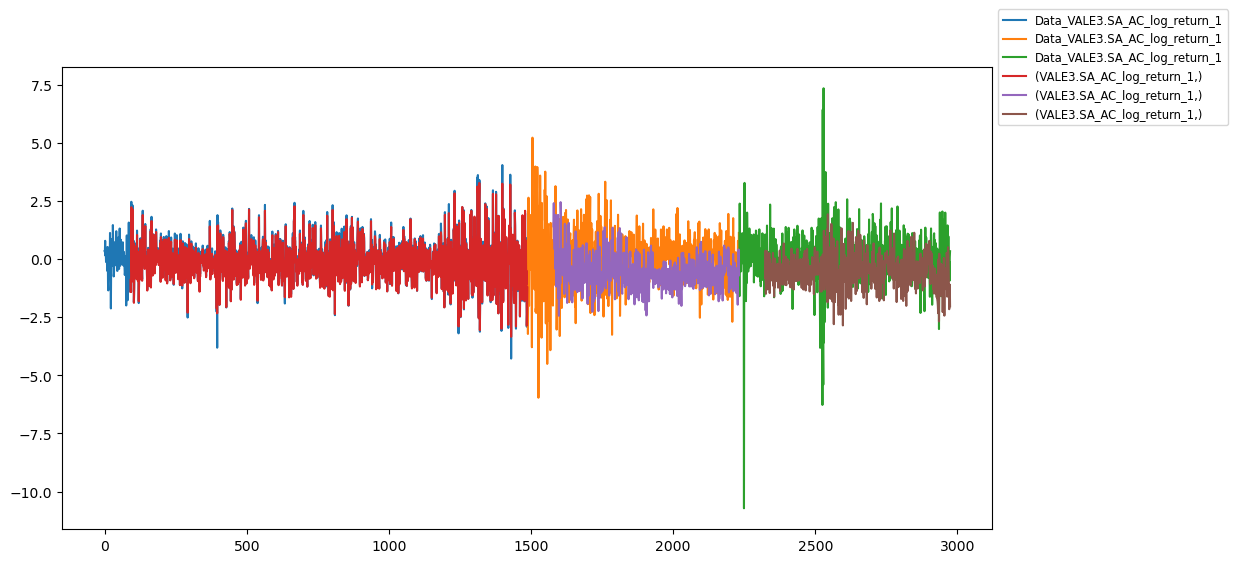

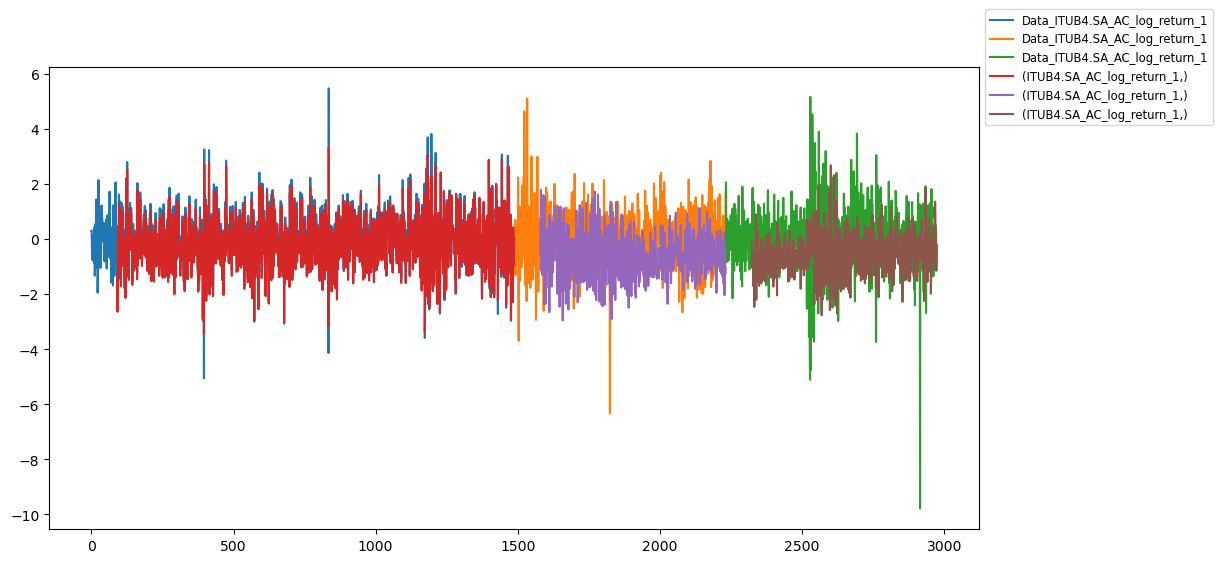

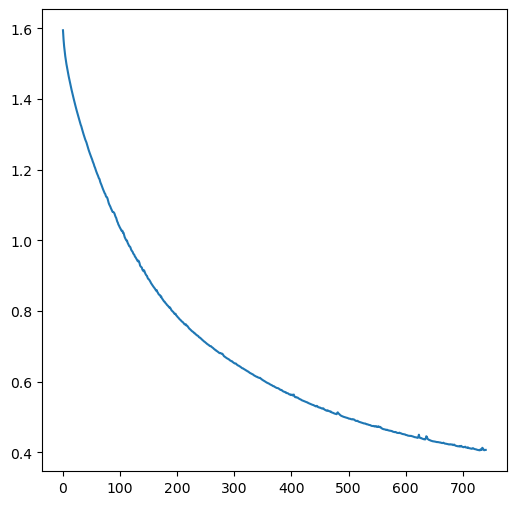

In [13]:
m.train_model()
m.plot()
m.calculate_metrics()
print("test pull sum =", m.test_pull.sum())
print("test chisq sum =", m.test_chisq.sum())
print("test mse sum =", sum(m.test_mse.values())/len(m.test_mse))

fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(m.regr.loss_curve_)
plt.show()

In [ ]:
mse = []
for rwin in range(1,120,10):
    m.set_pars(rwin,learning_rate,tolerance_rate,hidden_layers)
    m.split_data()
    m.create_samples()
    m.train_model()
    m.calculate_validation_mse()
    print(sum(m.validation_mse.values())/len(m.validation_mse))
    mse.append(sum(m.validation_mse.values())/len(m.validation_mse))
   
plt.plot(mse)
plt.show()

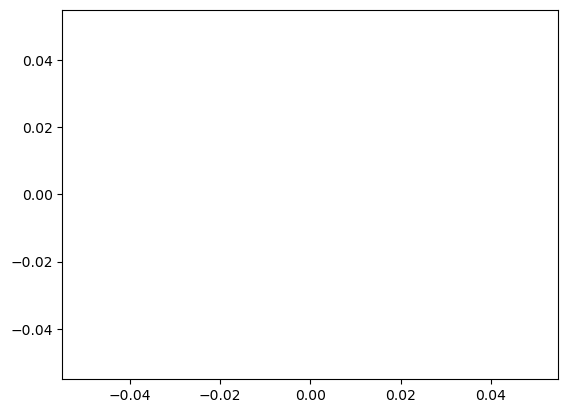

In [15]:
mse = []
rwin = 20
for L3 in range(5,35,5):
    for L2 in range(40,35,5):
        for L1 in range(70,130,5):
            print(L1,L2,L3)
            hidden_layers = [L1,L2,L3,6]
            m.set_pars(rwin,learning_rate,tolerance_rate,hidden_layers)
            m.split_data()
            m.create_samples()
            m.train_model()
            m.calculate_validation_mse()
            print(sum(m.validation_mse.values())/len(m.validation_mse))
            mse.append(sum(m.validation_mse.values())/len(m.validation_mse))
   
plt.plot(mse)
plt.show()


In [ ]:
opt_model = optimze_model(m,features,targets)

rwin = 90
rwin_bounds = (1,120)
learning_rate = 0.0006
learning_rate_bounds = (0.0006,0.0006)
tolerance_rate = 0.001
#tolerance_rate_bounds = (0.000000001,0.01)
tolerance_rate_bounds = (0.01,0.01)
hidden_layers = [20,50,20]
#hidden_layers_bounds = [(1,100),(1,100),(1,100),(1,100),(1,100)]
hidden_layers_bounds = [(20,20),(50,50),(20,20)]
isInt = [True,False,False,True,True,True]


opt_model.set_pars(rwin, 
                   rwin_bounds, 
                   learning_rate, 
                   learning_rate_bounds, 
                   tolerance_rate, 
                   tolerance_rate_bounds, 
                   hidden_layers, 
                   hidden_layers_bounds,isInt)

In [ ]:
optimal_pars = opt_model.differential_evolution(isInt)
print (optimal_pars)
opt_model.model.plot()

In [ ]:
optimal_pars = opt_model.dual_annealing()
print (optimal_pars)


In [ ]:
import torch
from torch import nn
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))
print(h0,c0,hn,cn,output)

In [ ]:
df = pd.DataFrame(np.random.rand(5, 3), columns=list('abc'))
print(df)
print(df.index)
df = df[1:5]
print(df)
print(df.iloc[1])


In [ ]:
df1 = pd.DataFrame(np.random.rand(5, 3), columns=list('abc'))

# Create the second DataFrame with shifted indices
df2 = pd.DataFrame(np.random.rand(5, 3), columns=list('def'), index=range(1, 6))

# Find the common indices between df1 and df2
common_indices = df1.index.intersection(df2.index)

# Use loc[] to select only the rows with common indices from each DataFrame
df1_common = df1.loc[common_indices]
df2_common = df2.loc[common_indices]

# Now you can perform operations between df1_common and df2_common without getting NaN values
result = df1_common + df2_common
print(result)

In [ ]:
coefs = regr.coefs_
# Iterate through the weights of each layer
for i, coef in enumerate(coefs):
    print(f"Layer {i}:")
    for j, weights in enumerate(columns):
        for k, weight in enumerate(weights):
            for l, element in enumerate(weight):
                print(f"    Weight from input feature {k} to neuron {j} of prediction of {l} in layer {i}: {element}")
layer_1_coefficients = coefs[0]
print(layer_1_coefficients[:,0])

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))
plt.plot(layer_1_coefficients[:,0])